# LSST CCOB ghost basic fit to the geometry

Show a first implementation of fitting geometry to a set of ghosts catalogs

## TODO
- understand uncertainties on parameters and compare to needed values
- move code to module
- fit multiple ghosts catalogs at a time 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize_scalar, minimize

import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import reduce_ghosts, compute_ghost_separations
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1
from ghosts.geom_configs import GEOM_CONFIG_0


In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 9000 pixels per mm^2


### True ghosts catalog ~ real data
- Build an aligned telescope, choose one CCOB ghost config, generate ghosts catalog

In [4]:
# A few numbers, sepcific to 600 nm
beam_power_600nm = 13  # 13 Watt for the full spot according to measurements done in Grenoble
ccd_reflectivity_600nm = 0.141338
ccd_qe_600nm = 0.843274
lens_reflectivity_600nm = 0.004  # 0.4% code by Julien Bolmont
filter_reflectivity_600nm = 0.038  # r band filter documentation stated transmission is 96.2%

# CCOB like geometry, i.e. lenses but no filter
ref_telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_aligned.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(ref_telescope, coating='smart',
                                    r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])

0

In [5]:
# Cool ghost configuration
ref_beam = copy.deepcopy(BEAM_CONFIG_0)
ref_beam['beam_id'] = 999042
ref_beam['n_photons'] = 10000
ref_beam['x_offset'] = +0.3
ref_beam['y_offset'] = -0.55
ref_beam['x_euler'] = -17
ref_beam['y_euler'] = -6

# make a copy with less photons for the fit
fit_beam = copy.deepcopy(ref_beam)
fit_beam['n_photons'] = 1000

In [6]:
# Ray trace one config for debugging
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(ref_telescope, beam_config=ref_beam)
simulation = [trace_full, r_forward, r_reverse, rays]

# reduce ghosts
ref_spots_data, _spots = reduce_ghosts(r_forward)
ref_spots_data_frame = make_data_frame(ref_spots_data, beam_id=ref_beam['beam_id'], geom_id=0)
ref_gh_sep = compute_ghost_separations(ref_spots_data_frame)
ref_spots_data_frame.sort_values(by=['name'])

beam_id  geom_id  index                        name     pos_x     std_x  \
12   999042        0     12     (Detector, L2_entrance) -0.016790  0.000489   
13   999042        0     13         (Detector, L2_exit) -0.043921  0.000159   
14   999042        0     14     (Detector, L3_entrance)  0.104801  0.000560   
15   999042        0     15         (Detector, L3_exit)  0.123004  0.000614   
0    999042        0      0      (L1_exit, L1_entrance) -0.027524  0.000241   
3    999042        0      3      (L2_entrance, L1_exit) -0.046037  0.000341   
1    999042        0      1      (L2_exit, L1_entrance)  0.139661  0.000873   
2    999042        0      2          (L2_exit, L1_exit)  0.257865  0.001340   
4    999042        0      4      (L2_exit, L2_entrance)  0.245685  0.001042   
7    999042        0      7  (L3_entrance, L1_entrance)  0.074599  0.000928   
8    999042        0      8  (L3_entrance, L2_entrance)  0.182817  0.001326   
9    999042        0      9      (L3_entrance, L2_exit)  0.088006  0.000738   
5    999042        0      5      (L3_exit, L2_entrance) -0.033806  0.000383   
6    999042        0      6          (L3_exit, L2_exit) -0.057584  0.000086   
10   999042        0     10      (L3_exit, L3_entrance)  0.109621  0.000557   
11   999042        0     11                (main, main)  0.129771  0.000617   

       pos_y     std_y   width_x   width_y    radius    radius_err  \
12  0.312480  0.000489  0.001976  0.001936  0.000978  1.997477e-05   
13  0.218486  0.000159  0.000642  0.000541  0.000296  5.050226e-05   
14 -0.010240  0.000560  0.002265  0.002244  0.001127  1.022416e-05   
15 -0.033610  0.000614  0.002480  0.002478  0.001239  1.121306e-06   
0   0.211851  0.000241  0.000971  0.000756  0.000432  1.074888e-04   
3   0.315325  0.000341  0.001380  0.001292  0.000668  4.389417e-05   
1   0.055484  0.000873  0.003527  0.003496  0.001756  1.552941e-05   
2  -0.041883  0.001340  0.005417  0.005356  0.002693  3.077011e-05   
4  -0.172800  0.001042  0.004210  0.004063  0.002068  7.359033e-05   
7   0.274421  0.000928  0.003753  0.003752  0.001876  6.266409e-07   
8   0.165942  0.001326  0.005360  0.005541  0.002725  9.032684e-05   
9   0.133137  0.000738  0.002983  0.002981  0.001491  1.256896e-06   
5   0.308292  0.000383  0.001548  0.001442  0.000748  5.296931e-05   
6   0.220870  0.000086  0.000349  0.000233  0.000145  5.772615e-05   
10 -0.026537  0.000557  0.002253  0.002235  0.001122  9.290515e-06   
11 -0.052096  0.000617  0.002496  0.002494  0.001247  7.767786e-07   

           flux    surface  n_pixels  pixel_signal  
12     4.626507   3.006053     27054  4.390436e+03  
13     4.663742   0.274488      2470  4.846872e+04  
14     4.701277   3.991894     35927  3.359602e+03  
15     4.739115   4.826152     43435  2.801219e+03  
0      0.134121   0.585311      5268  6.536765e+02  
3      0.134121   1.402367     12621  2.728271e+02  
1      0.131988   9.686287     87177  3.887131e+01  
2      0.133051  22.787203    205085  1.665624e+01  
4      0.134121  13.438349    120945  2.847104e+01  
7      0.130935  11.059639     99537  3.377258e+01  
8      0.133051  23.329856    209969  1.626881e+01  
9      0.134121   6.984545     62861  5.477861e+01  
5      0.131988   1.756270     15806  2.143854e+02  
6      0.133051   0.066497       598  5.707721e+03  
10     0.134121   3.954704     35592  9.674648e+01  
11  8382.590951   4.888067     43993  4.892063e+06

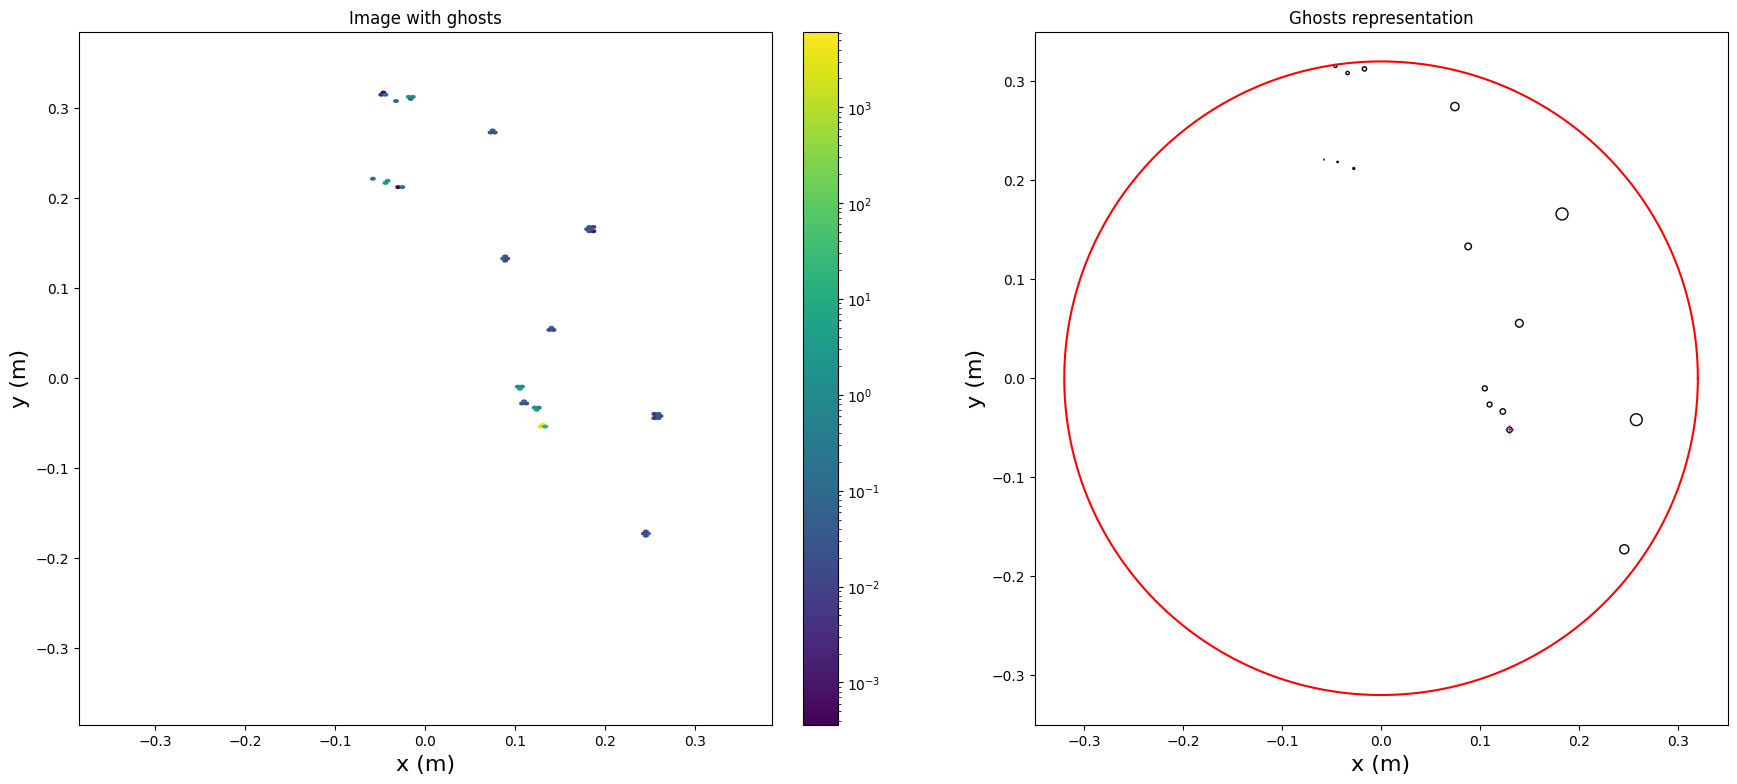

In [7]:
# plot focal plane
_fig, _ax = plotter.plot_full_camera_and_spots(r_forward, ref_spots_data_frame, log_scale=True)

### Basic fit over one lens rotation

In [8]:
def basic_build_telescope_to_fit(L1_rx):
    """ Build telescope to fit from reference telescope
    """
    # Build telescope
    fitted_geom_config = {'L1_rx': L1_rx}
    fitted_telescope = tweak_optics.tweak_telescope(ref_telescope, fitted_geom_config)
    # Make refractive interfaces partially reflective
    tweak_optics.make_optics_reflective(fitted_telescope, coating='smart',
                                        r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])
    return fitted_telescope


def basic_compute_distance(L1_rx):
    """ Callable function for the fit
    """
    # new telescope
    fitted_telescope = basic_build_telescope_to_fit(L1_rx)
    fit_spots_df = simulator.run_and_analyze_simulation(fitted_telescope, geom_id=0, beam_config=fit_beam)
    # match ghosts
    match = match_ghosts(ref_spots_data_frame, fit_spots_df, radius_scale_factor=10)
    dist_2d = compute_2d_reduced_distance(match)
    #print(f'L1_rx={L1_rx}\tDistance={dist_2d}')
    return dist_2d


In [9]:
# Do a very basic fit using a scalar function
bounded_opts = {'maxiter':100, 'xatol':1e-7, 'disp':3}
res = minimize_scalar(basic_compute_distance, bounds=(-0.1, 0.1), method='bounded', options=bounded_opts)
print(f'\nMinimal distance is {res.fun}')
print(f'for L1 rotation around x to be L1_rx={res.x}')  # minimizer

 
 Func-count     x          f(x)          Procedure
    1     -0.0236068  0.000108686        initial
    2      0.0236068  0.000108219        golden
    3      0.0527864  0.000240785        golden
    4    8.29633e-05  7.98874e-06        parabolic
    5     2.7428e-05  9.78423e-06        parabolic
    6      0.0104721  5.23016e-05        parabolic
    7     0.00405125  2.11252e-05        golden
    8     0.00188024  1.42116e-05        parabolic
    9    0.000891985  5.86635e-06        parabolic
   10    0.000525648  1.73144e-05        parabolic
   11     0.00126946  1.32013e-05        golden
   12     0.00103617  1.84009e-05        golden
   13    0.000752057  6.54478e-06        golden
   14    0.000947059  1.12181e-05        golden
   15    0.000838538   1.3895e-05        golden
   16    0.000913022  5.06258e-06        golden
   17    0.000926023  8.46347e-06        golden
   18    0.000904986  8.85532e-06        golden
   19    0.000917988  4.27973e-06        golden
   20    0.00092

In [10]:
fit = """ Func-count     x          f(x)          Procedure
    1     -0.0236068  0.000106797        initial
    2      0.0236068  0.000106329        golden
    3      0.0527864  0.000243869        golden
    4    8.02143e-05  3.93155e-06        parabolic
    5    2.69311e-05  1.91557e-05        parabolic
    6      0.0116666  5.38016e-05        parabolic
    7     0.00450582  1.74659e-05        golden
    8      0.0022693  1.42141e-05        parabolic
    9    0.000916371  9.95764e-06        golden
   10    0.000399598  1.53059e-05        golden
   11    0.000202208  8.93834e-06        golden
   12    0.000126812  1.08775e-05        golden
   13    5.98619e-05  8.97804e-06        golden
   14     9.8013e-05   8.3121e-06        golden
   15    7.24404e-05  1.32094e-05        golden
   16    8.70128e-05  9.13171e-06        golden
   17     7.7245e-05  7.35218e-06        golden
   18    8.28111e-05  9.71879e-06        golden
   19    7.90801e-05  5.38447e-06        golden
   20    8.12062e-05  2.65994e-06        golden
   21    8.18192e-05  1.82527e-06        golden
   22    8.21981e-05  1.30709e-05        golden
   23    8.15851e-05  2.75212e-06        golden
   24     8.1964e-05  7.02504e-06        golden
   25    8.17298e-05  3.59333e-06        golden
   26    8.18745e-05  7.21426e-06        golden
   27    8.17851e-05  7.38041e-06        golden"""

In [11]:
from io import StringIO
fdf=pd.read_csv(StringIO(fit), delim_whitespace=True, engine='python')
fdf.head()

Func-count         x      f(x)  Procedure
0           1 -0.023607  0.000107    initial
1           2  0.023607  0.000106     golden
2           3  0.052786  0.000244     golden
3           4  0.000080  0.000004  parabolic
4           5  0.000027  0.000019  parabolic

<AxesSubplot:xlabel='x', ylabel='f(x)'>

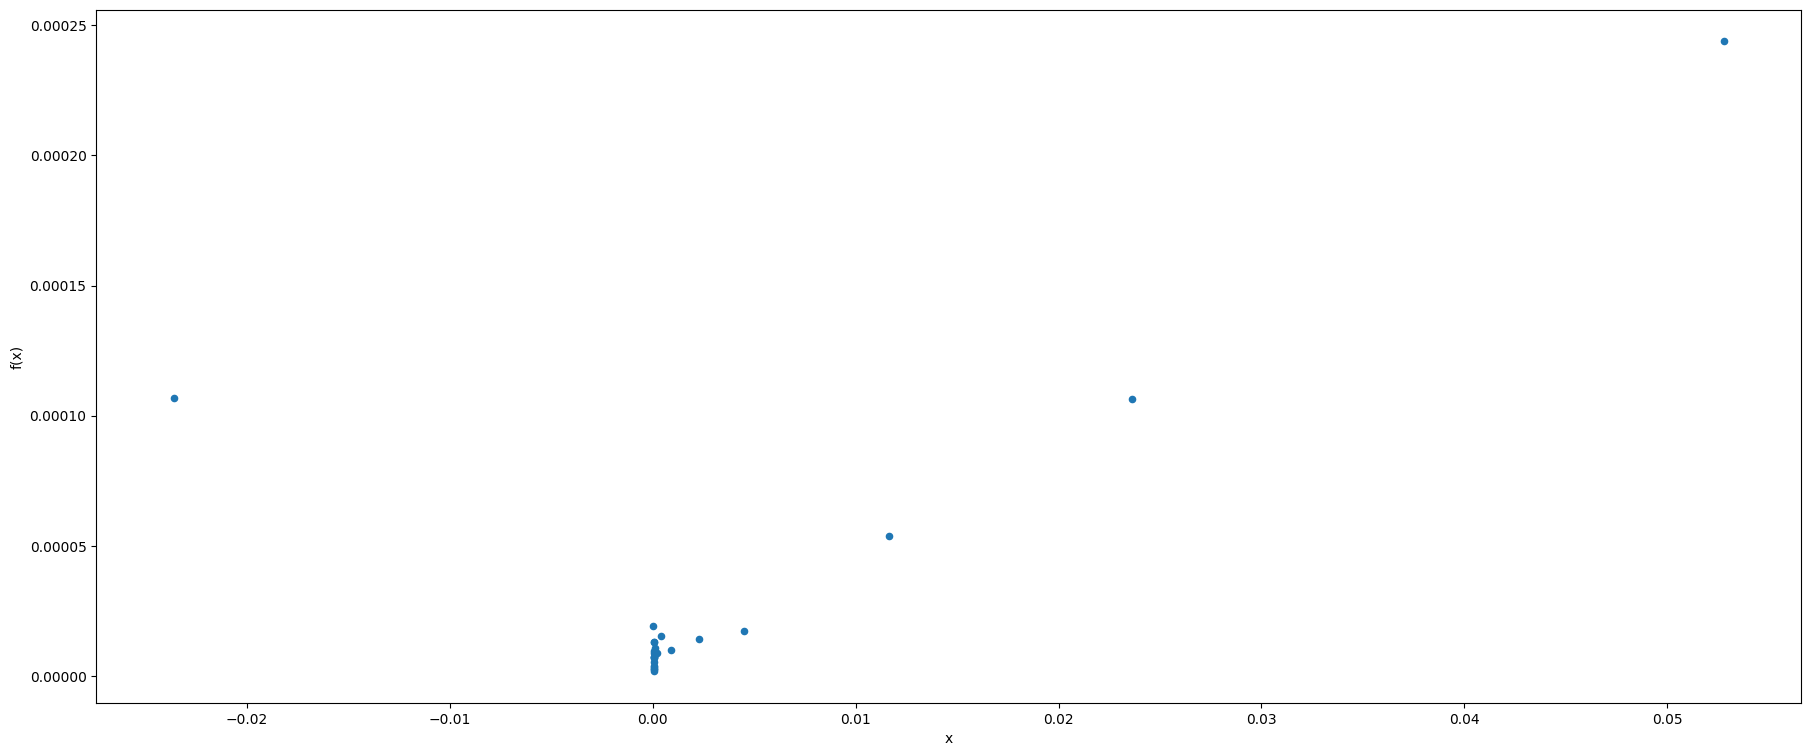

In [12]:
fdf.plot.scatter('x', 'f(x)')

## Smarter fit over one lens but all parameters

In [13]:
def unpack_geom_params(geom_params):
    fitted_geom_config = {'L1_dx': geom_params[0], 'L1_dy': geom_params[1], 'L1_dz': geom_params[2],
                          'L1_rx': geom_params[3], 'L1_ry': geom_params[4]}
    return fitted_geom_config


def smart_build_telescope_to_fit(geom_params):
    """ Build telescope to fit from reference telescope
    """
    # Build telescope
    fitted_geom_config = unpack_geom_params(geom_params)
    fitted_telescope = tweak_optics.tweak_telescope(ref_telescope, fitted_geom_config)
    # Make refractive interfaces partially reflective
    tweak_optics.make_optics_reflective(fitted_telescope, coating='smart',
                                        r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])
    return fitted_telescope

res_store = []
def smart_compute_distance(geom_params):
    """ Callable function for the fit
    """
    # new telescope
    fitted_telescope = smart_build_telescope_to_fit(geom_params)
    fit_spots_df = simulator.run_and_analyze_simulation(fitted_telescope, geom_id=0, beam_config=fit_beam)
    # match ghosts
    match = match_ghosts(ref_spots_data_frame, fit_spots_df, radius_scale_factor=10)
    dist_2d = compute_2d_reduced_distance(match)
    fitted_geom_config = unpack_geom_params(geom_params)
    if not np.random.randint(10)%9:
        print(f'{dist_2d:.6f} {fitted_geom_config["L1_dx"]:.6f} {fitted_geom_config["L1_dy"]:.6f} {fitted_geom_config["L1_dz"]:.6f} {fitted_geom_config["L1_rx"]:.6f} {fitted_geom_config["L1_ry"]:.6f}')
    res_store.append([dist_2d,
                      fitted_geom_config['L1_dx'], fitted_geom_config['L1_dy'], fitted_geom_config['L1_dz'],
                      fitted_geom_config['L1_rx'], fitted_geom_config['L1_ry']])
    return dist_2d

def smart_fit_callback(geom_params):
    fitted_geom_config = unpack_geom_params(geom_params)
    #print(fitted_geom_config['L1_rx'], fitted_geom_config['L1_ry'])


### Nelder-Mead

In [14]:
# try to fit again
res_store = []
# https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html#optimize-minimize-neldermead
nm_opts = {'disp': True, 'maxfev': 1000, 'xatol': 1e-6, 'return_all': True, 'adaptive': True}
list_of_bounds = [(-0.1, 0.1), (-0.1, 0.1), (-0.1, 0.1), (-0.1, 0.1), (-0.1, 0.1)]
geom_params_init = [0.0, 0.0, 0.0, 0.0, 0.0]
res = minimize(smart_compute_distance, geom_params_init, bounds=list_of_bounds,
               method='Nelder-Mead', options=nm_opts,
               callback=smart_fit_callback)
print(res.nit, res.fun, res.x)

0.000025 0.000163 0.000017 0.000017 0.000017 0.000017
0.000023 0.000077 -0.000133 -0.000072 0.000126 0.000126
0.000021 -0.000062 -0.000108 0.000091 0.000110 0.000110
0.000010 0.000096 0.000014 0.000016 0.000041 0.000041
0.000009 0.000000 0.000000 0.000000 0.000200 0.000050
0.000008 -0.000058 0.000024 -0.000046 0.000105 0.000155
0.000013 -0.000042 0.000005 0.000007 0.000165 -0.000011
0.000005 0.000003 0.000044 0.000003 0.000056 0.000101
0.000017 -0.000006 0.000008 0.000007 0.000023 0.000203
0.000010 -0.000009 0.000015 0.000007 0.000057 0.000115
0.000008 -0.000032 0.000020 -0.000009 0.000081 0.000136
0.000008 -0.000009 0.000030 -0.000023 0.000105 0.000121
0.000009 -0.000013 0.000013 0.000009 0.000064 0.000171
0.000014 -0.000003 0.000004 -0.000009 0.000098 0.000163
0.000002 -0.000010 0.000014 0.000006 0.000079 0.000153
0.000012 -0.000010 0.000012 0.000007 0.000110 0.000107
0.000010 -0.000010 0.000016 0.000009 0.000119 0.000115
0.000005 0.000001 0.000019 -0.000004 0.000076 0.000167
0.00000

In [15]:
res

       allvecs: [array([0., 0., 0., 0., 0.]), array([0.     , 0.     , 0.     , 0.     , 0.00025]), array([0.     , 0.     , 0.     , 0.     , 0.00025]), array([0.     , 0.     , 0.     , 0.     , 0.00025]), array([0.     , 0.     , 0.     , 0.     , 0.00025]), array([0.     , 0.     , 0.     , 0.     , 0.00025]), array([0.     , 0.     , 0.     , 0.     , 0.00025]), array([0.     , 0.     , 0.     , 0.     , 0.00025]), array([0.     , 0.     , 0.     , 0.     , 0.00025]), array([0.     , 0.     , 0.     , 0.     , 0.00025]), array([0.     , 0.     , 0.     , 0.     , 0.00025]), array([0.     , 0.     , 0.     , 0.     , 0.00025]), array([ 8.04938786e-06,  6.37741769e-06, -4.55050590e-06,  2.47079001e-05,
        7.47079001e-05]), array([ 8.04938786e-06,  6.37741769e-06, -4.55050590e-06,  2.47079001e-05,
        7.47079001e-05]), array([ 8.04938786e-06,  6.37741769e-06, -4.55050590e-06,  2.47079001e-05,
        7.47079001e-05]), array([ 8.04938786e-06,  6.37741769e-06, -4.55050590e-06,

In [16]:
rdf = pd.DataFrame(res_store, columns=['distance', 'L1_dx', 'L1_dy', 'L1_dz', 'L1_rx', 'L1_ry'])
rdf.head()

distance    L1_dx    L1_dy    L1_dz    L1_rx  L1_ry
0  0.000011  0.00000  0.00000  0.00000  0.00000    0.0
1  0.000035  0.00025  0.00000  0.00000  0.00000    0.0
2  0.000035  0.00000  0.00025  0.00000  0.00000    0.0
3  0.000027  0.00000  0.00000  0.00025  0.00000    0.0
4  0.000007  0.00000  0.00000  0.00000  0.00025    0.0

<AxesSubplot:xlabel='L1_ry', ylabel='distance'>

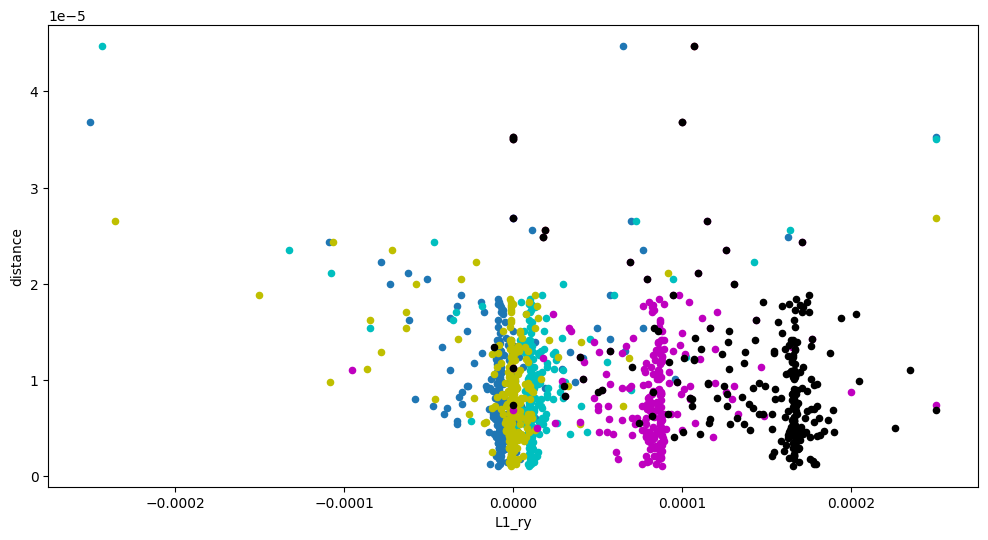

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
rdf.plot.scatter('L1_dx', 'distance', ax=ax)
rdf.plot.scatter('L1_dy', 'distance', ax=ax, color='c')
rdf.plot.scatter('L1_dz', 'distance', ax=ax, color='y')
rdf.plot.scatter('L1_rx', 'distance', ax=ax, color='m')
rdf.plot.scatter('L1_ry', 'distance', ax=ax, color='k')

### BFGS

In [18]:
# try to fit again
res_store = []
# https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html#optimize-minimize-neldermead
nm_opts = {'disp': True, 'gtol':1e-6}
list_of_bounds = [(-0.01, 0.01)]*5
geom_params_init = [0.0, 0.0, 0.0, 0.0, 0.0]
res = minimize(smart_compute_distance, geom_params_init, bounds=list_of_bounds,
               method='L-BFGS-B', options=nm_opts)
print(res.nit, res.fun, res.x)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64853D-05    |proj g|=  1.00000D-02
0.001876 0.010000 0.010000 0.010000 0.010000 0.010000
0.001874 0.010000 0.010000 0.010000 0.010000 0.010000
0.000600 0.003186 0.003186 0.003186 0.003186 0.003186
0.000173 0.000906 0.000906 0.000906 0.000906 0.000906
0.000164 0.000906 0.000906 0.000906 0.000906 0.000906
0.000010 0.000024 0.000024 0.000024 0.000024 0.000024
0.000010 0.000024 0.000024 0.000024 0.000024 0.000024
0.000009 0.000024 0.000024 0.000024 0.000024 0.000024
0.000017 0.000011 0.000011 0.000011 0.000011 0.000011
0.000007 0.000005 0.000005 0.000005 0.000005 0.000005
0.000013 0.000002 0.000002 0.000002 0.000002 0.000002

At iterate    1    f=  2.54895D-06    |proj g|=  1.00022D-02
0.000008 0.000002 0.000002 0.000002 0.000002 0.000002
0.000007 0.000002 0.000002 0.000002 0.000002 0.000002
0.00000

<AxesSubplot:xlabel='L1_ry', ylabel='distance'>

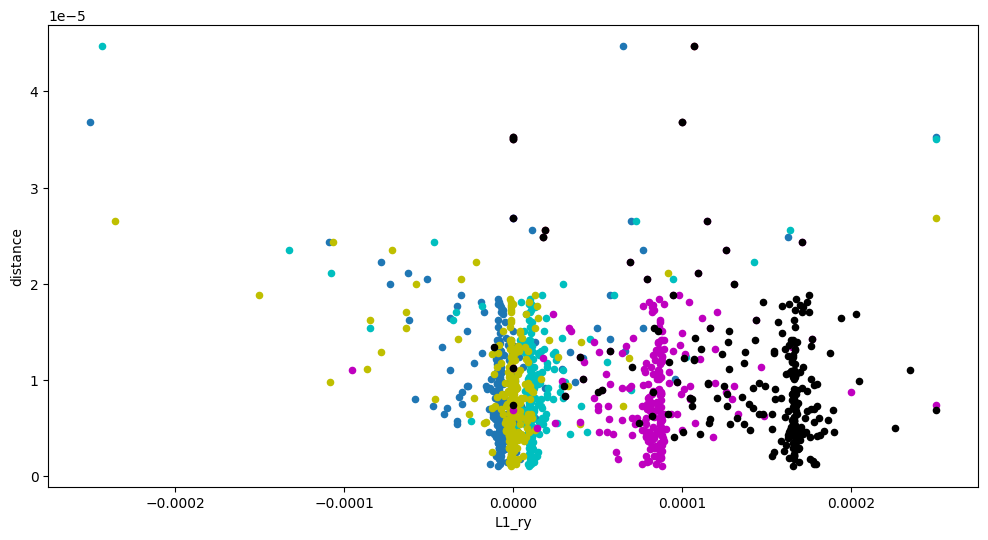

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
rdf.plot.scatter('L1_dx', 'distance', ax=ax)
rdf.plot.scatter('L1_dy', 'distance', ax=ax, color='c')
rdf.plot.scatter('L1_dz', 'distance', ax=ax, color='y')
rdf.plot.scatter('L1_rx', 'distance', ax=ax, color='m')
rdf.plot.scatter('L1_ry', 'distance', ax=ax, color='k')

### Gaussian Process minimizer
https://scikit-optimize.github.io/stable/getting_started.html

In [20]:
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

# list of bounds
dxs = [(-0.0005, 0.0005)]*3
rxs = [(-0.01, 0.01)]*2
list_of_bounds = (dxs+rxs)

# Should use callback function
res = gp_minimize(smart_compute_distance,                  # the function to minimize
                  list_of_bounds,     # the bounds on each dimension of x
                  acq_func="gp_hedge",      # the acquisition function
                  n_calls=200,        # the number of evaluations of f
                  n_random_starts=10,  # the number of random initialization points
                  noise=0.01**2,      # the noise level (optional)
                  random_state=1234,  # the random seed
                  n_jobs=8)            # parallel processing

0.000043 -0.000002 0.000318 0.000112 0.005427 0.007213
0.000090 -0.000349 -0.000301 0.000315 -0.006824 -0.007677
0.000018 -0.000047 0.000038 0.000291 -0.000683 -0.001293
0.000067 -0.000069 0.000252 -0.000270 -0.000592 0.008960
0.000062 -0.000252 0.000270 -0.000302 0.002374 0.006771
0.000051 -0.000001 0.000153 0.000121 -0.001720 0.009597
0.000055 -0.000219 0.000500 0.000500 0.010000 -0.005569
0.000049 0.000272 -0.000028 -0.000231 -0.001162 0.003293
0.000010 -0.000032 0.000068 0.000057 0.001060 -0.000860
0.000095 -0.000234 0.000397 -0.000160 -0.003653 0.003800
0.000017 -0.000091 -0.000111 -0.000115 -0.002076 0.004776
0.000036 -0.000170 0.000112 0.000330 -0.008256 0.001283
0.000040 0.000032 -0.000470 -0.000478 -0.003371 -0.002071
0.000083 0.000048 0.000351 -0.000387 0.000322 0.001606
0.000065 0.000495 0.000483 0.000407 0.000119 -0.008009
0.000066 0.000483 0.000007 0.000310 0.003717 -0.007041
0.000014 -0.000034 0.000039 0.000025 -0.000922 0.000584
0.000052 0.000343 -0.000077 0.000281 -0.00

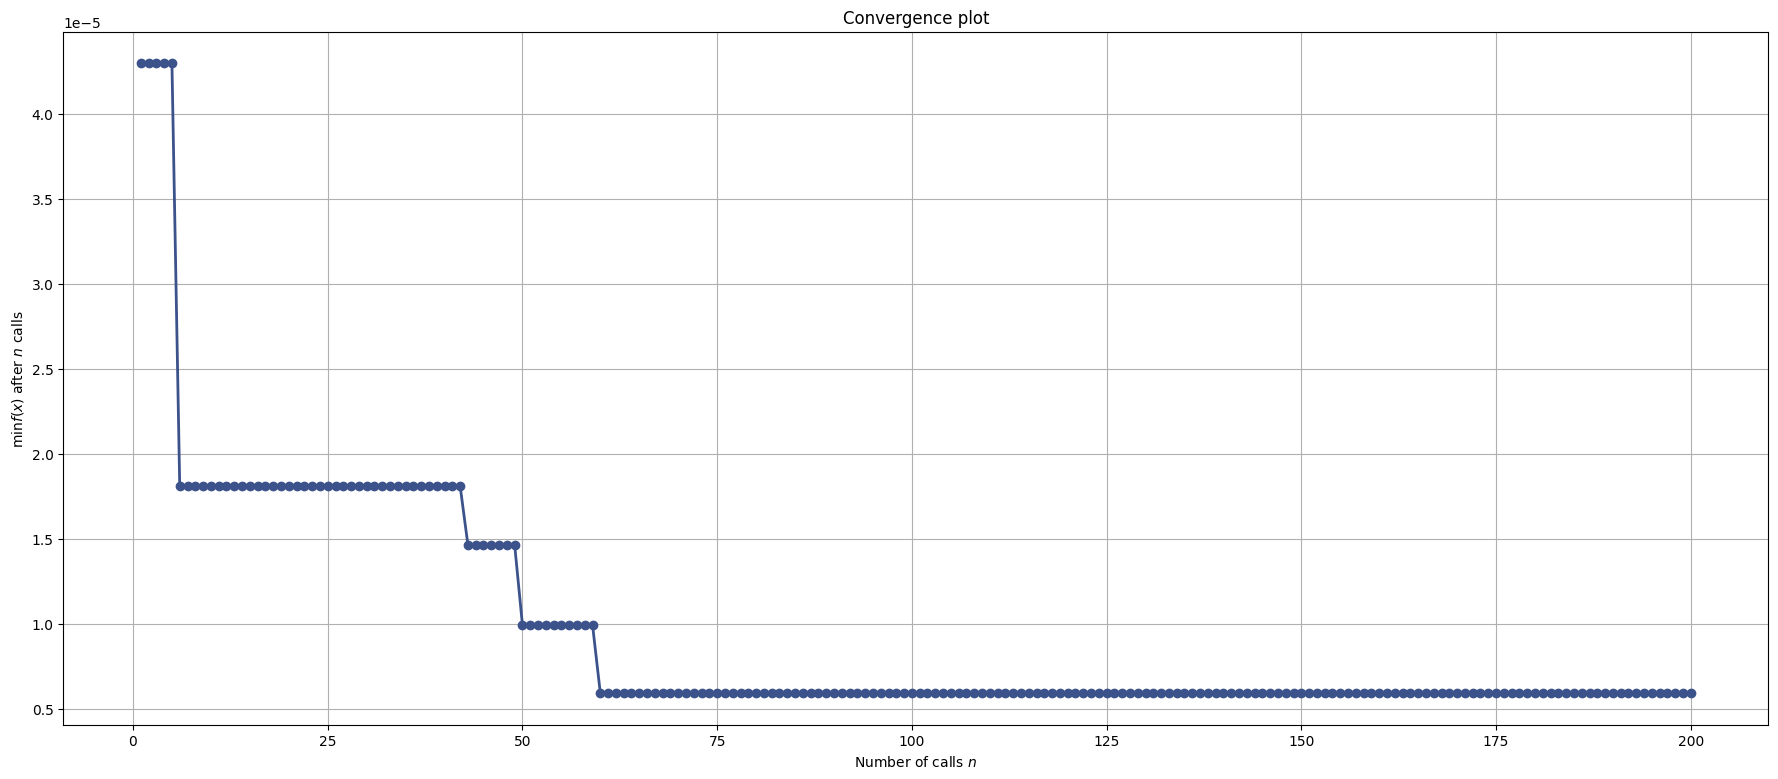

In [21]:
_ = plot_convergence(res)

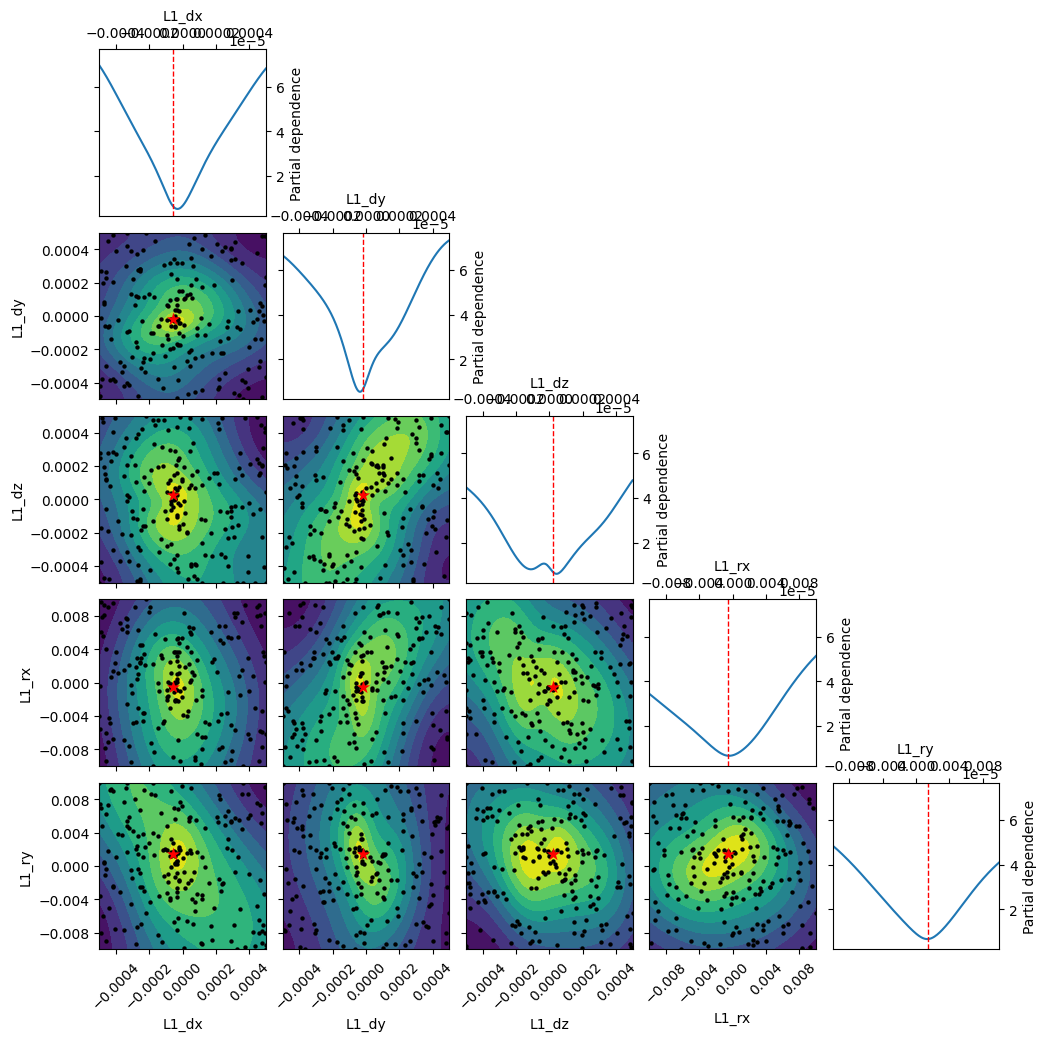

In [22]:
labels = ["L1_dx", "L1_dy", "L1_dz", "L1_rx", "L1_ry"]
_ = plot_objective(res,  sample_source='result', n_points=200, dimensions=labels)


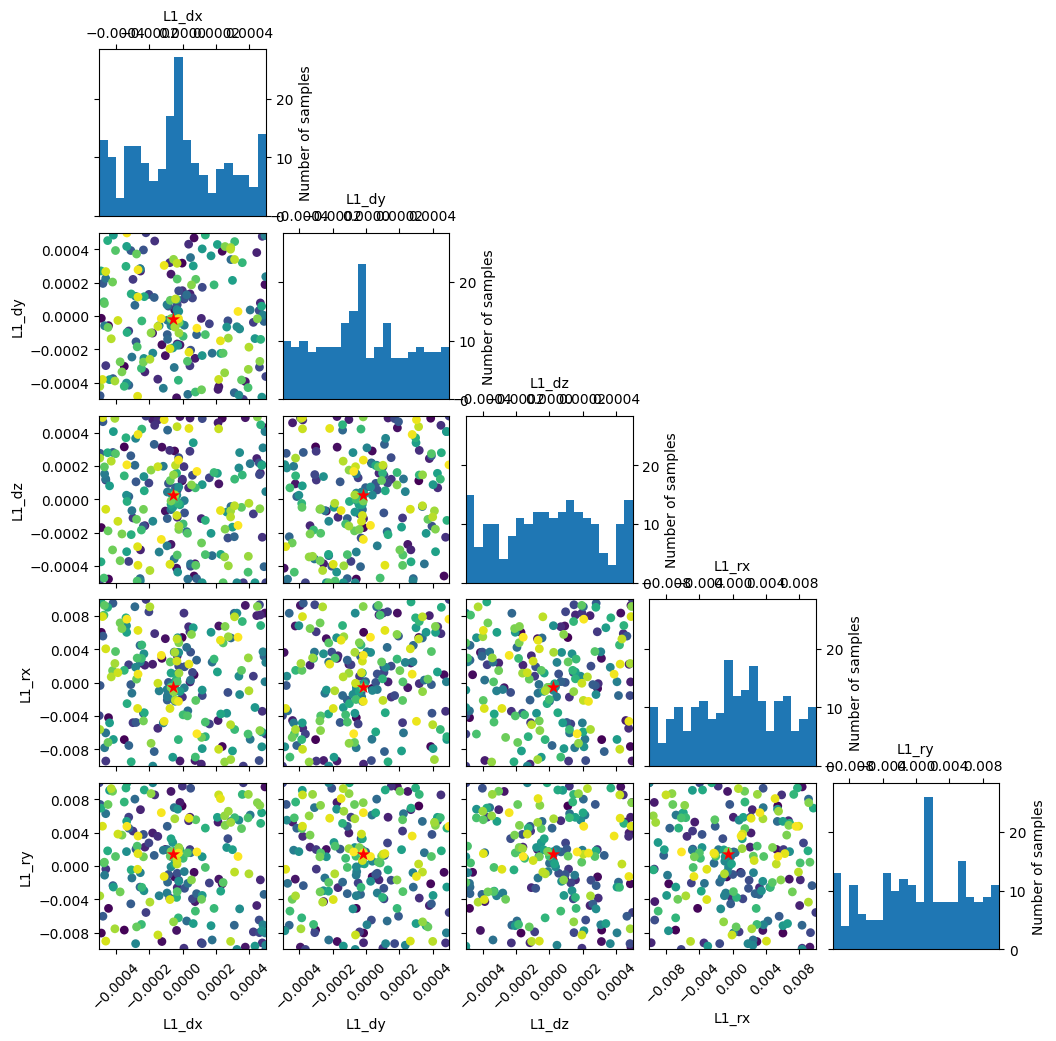

In [23]:
_ = plot_evaluations(res, dimensions=labels)

### Gaussian process all parameters using first gp_minimize and then a controlled loop

In [24]:
def unpack_all_geom_params(geom_params):
    fitted_geom_config = {'L1_dx': geom_params[0], 'L1_dy': geom_params[1], 'L1_dz': geom_params[2],
                          'L1_rx': geom_params[3], 'L1_ry': geom_params[4],
                          'L2_dx': geom_params[5], 'L2_dy': geom_params[6], 'L2_dz': geom_params[7],
                          'L2_rx': geom_params[8], 'L2_ry': geom_params[9],
                          'L3_dx': geom_params[10], 'L3_dy': geom_params[11], 'L3_dz': geom_params[12],
                          'L3_rx': geom_params[13], 'L3_ry': geom_params[14]}
    return fitted_geom_config


def build_full_telescope_to_fit(geom_params):
    """ Build telescope to fit from reference telescope
    """
    # Build telescope
    fitted_geom_config = unpack_all_geom_params(geom_params)
    fitted_telescope = tweak_optics.tweak_telescope(ref_telescope, fitted_geom_config)
    # Make refractive interfaces partially reflective
    tweak_optics.make_optics_reflective(fitted_telescope, coating='smart',
                                        r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])
    return fitted_telescope


def full_compute_distance(geom_params):
    """ Callable function for the fit
    """
    # new telescope
    fitted_telescope = build_full_telescope_to_fit(geom_params)
    fit_spots_df = simulator.run_and_analyze_simulation(fitted_telescope, geom_id=0, beam_config=fit_beam)
    # match ghosts
    match = match_ghosts(ref_spots_data_frame, fit_spots_df, radius_scale_factor=10)
    dist_2d = compute_2d_reduced_distance(match)
    fitted_geom_config = unpack_all_geom_params(geom_params)
    if not np.random.randint(10)%9:
        print(f'{dist_2d:.6f} {fitted_geom_config["L1_dx"]:.6f} {fitted_geom_config["L1_dy"]:.6f} {fitted_geom_config["L1_dz"]:.6f} {fitted_geom_config["L1_rx"]:.6f} {fitted_geom_config["L1_ry"]:.6f}', end=" ")
        print(f'{dist_2d:.6f} {fitted_geom_config["L2_dx"]:.6f} {fitted_geom_config["L2_dy"]:.6f} {fitted_geom_config["L2_dz"]:.6f} {fitted_geom_config["L2_rx"]:.6f} {fitted_geom_config["L2_ry"]:.6f}', end=" ")
        print(f'{dist_2d:.6f} {fitted_geom_config["L3_dx"]:.6f} {fitted_geom_config["L3_dy"]:.6f} {fitted_geom_config["L3_dz"]:.6f} {fitted_geom_config["L3_rx"]:.6f} {fitted_geom_config["L3_ry"]:.6f}')
    return dist_2d



### gp_minimize

In [25]:
from skopt import gp_minimize, expected_minimum
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

# list of bounds
dxs = [(-0.0005, 0.0005)]*3
rxs = [(-0.01, 0.01)]*2
list_of_bounds = (dxs+rxs)+(dxs+rxs)+(dxs+rxs)

# Should use callback function
res = gp_minimize(full_compute_distance,                  # the function to minimize
                  list_of_bounds,     # the bounds on each dimension of x
                  acq_func="gp_hedge",      # the acquisition function
                  n_calls=200,        # the number of evaluations of f
                  n_random_starts=10,  # the number of random initialization points
                  noise=0.1**2,      # the noise level (optional)
                  random_state=1234,  # the random seed
                  n_jobs=8)            # parallel processing

expected_minimum(res)

0.000176 -0.000002 0.000318 0.000112 0.005427 0.007213 0.000176 -0.000349 -0.000301 0.000315 -0.006824 -0.007677 0.000176 -0.000487 -0.000013 -0.000169 0.006053 -0.008035
0.000149 -0.000444 -0.000057 -0.000478 -0.004185 -0.005072 0.000149 0.000238 0.000389 0.000487 -0.007651 -0.002124 0.000149 -0.000047 0.000038 0.000291 -0.000683 -0.001293
0.000182 -0.000103 -0.000237 -0.000070 0.005291 0.001995 0.000182 -0.000419 0.000205 -0.000336 -0.009353 -0.003437 0.000182 -0.000026 -0.000432 -0.000117 -0.007629 0.007927
0.000093 0.000273 -0.000473 -0.000279 -0.007593 -0.006495 0.000093 -0.000071 0.000158 0.000066 0.001381 0.003084 0.000093 -0.000131 0.000452 -0.000303 0.006999 0.009209
0.000152 0.000290 0.000218 0.000110 -0.007231 -0.002320 0.000152 -0.000225 -0.000055 0.000485 0.002175 -0.008207 0.000152 0.000239 0.000313 0.000022 -0.004769 -0.008691
0.000081 -0.000406 0.000089 0.000111 -0.006906 0.000266 0.000081 -0.000371 0.000195 -0.000010 -0.004273 -0.001481 0.000081 0.000133 0.000058 0.000

([-7.897341445874181e-05,
  -0.00013075768284753127,
  0.00010698820856162926,
  -0.01,
  -0.01,
  -9.511602500397252e-06,
  -8.092844080614465e-05,
  4.735681983299854e-05,
  -0.007960956993608711,
  -0.00928116914094897,
  -2.6427321316370503e-05,
  -7.997833098535419e-07,
  -2.840554051008488e-05,
  -0.00445399789706857,
  -0.006947573425386455],
 4.396880438855461e-05)

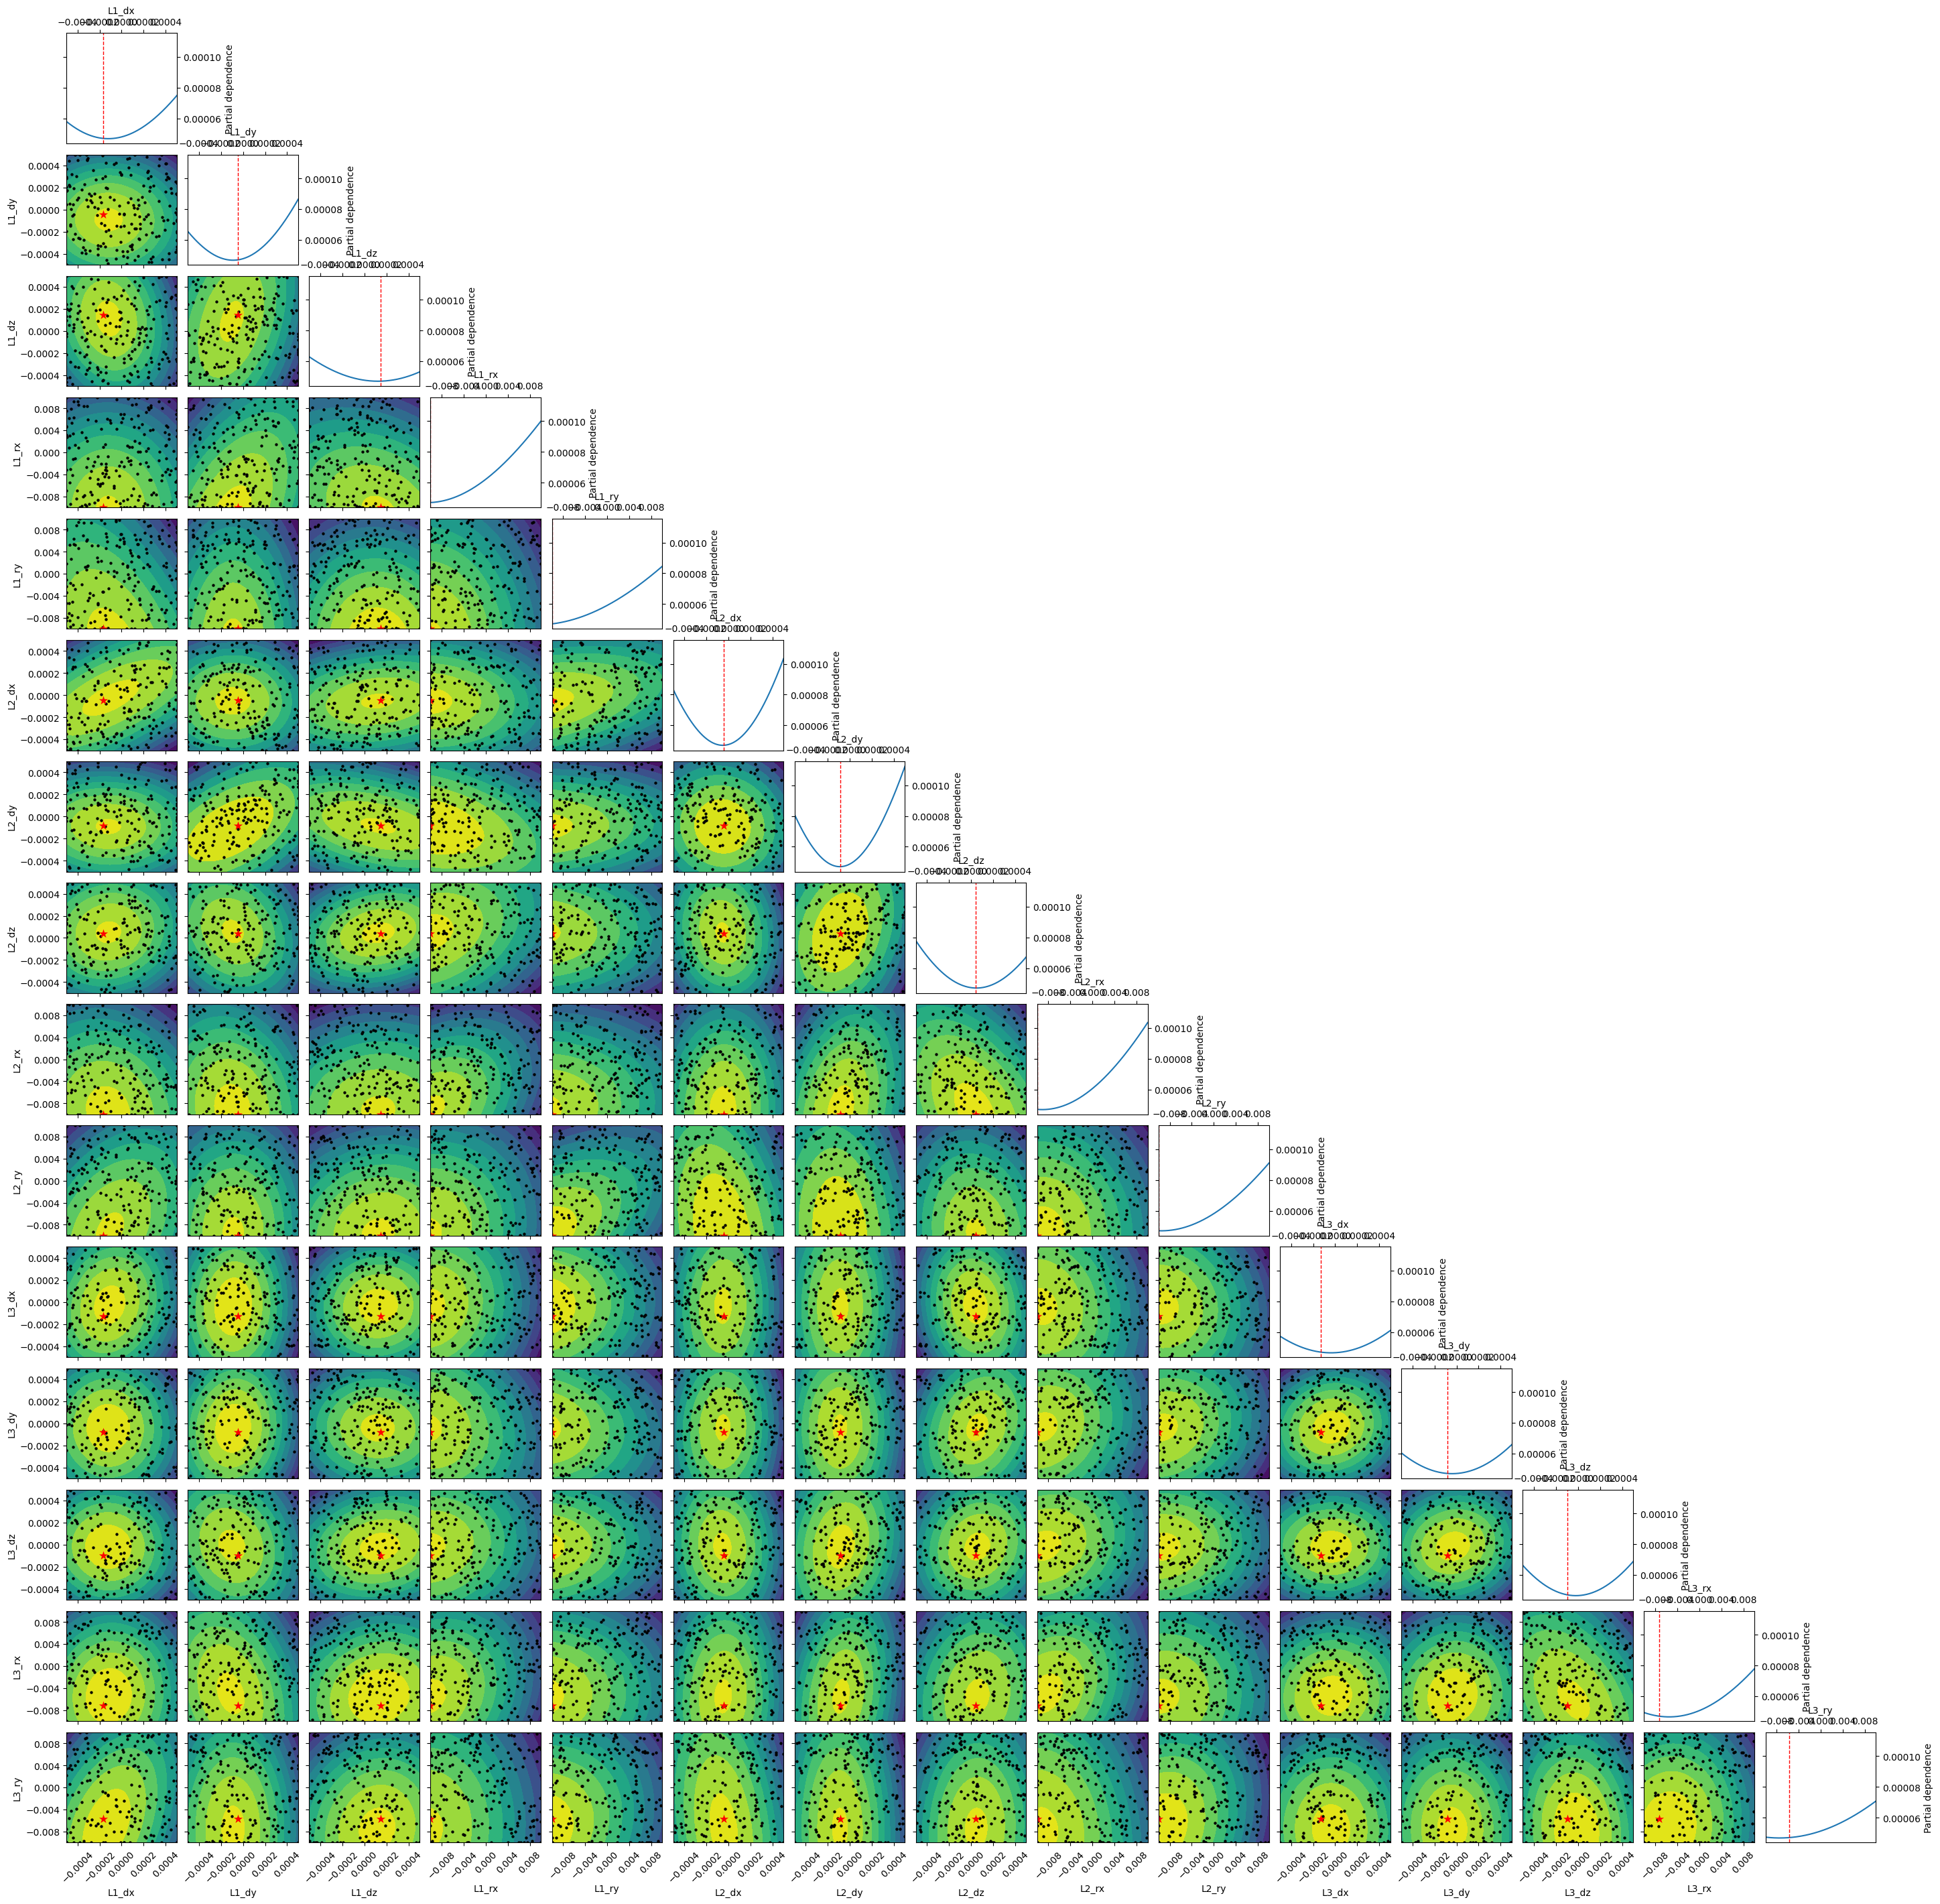

In [26]:
labels = ["L1_dx", "L1_dy", "L1_dz", "L1_rx", "L1_ry",
          "L2_dx", "L2_dy", "L2_dz", "L2_rx", "L2_ry",
          "L3_dx", "L3_dy", "L3_dz", "L3_rx", "L3_ry"]

_ = plot_objective(res,  sample_source='result', n_points=200, dimensions=labels)


### controlled loop

In [29]:
from skopt import Optimizer, expected_minimum

# bounds
dxs = [(-0.0005, 0.0005)]*3
rxs = [(-0.01, 0.01)]*2
list_of_bounds = (dxs+rxs)+(dxs+rxs)+(dxs+rxs)

# n_calls
gp_ncalls = 500

# create optimizer
opt = Optimizer(list_of_bounds, n_jobs=8)

# minimize
for i in range(gp_ncalls):
    suggested = opt.ask()
    distance = full_compute_distance(suggested)
    opt.tell(suggested, distance)

res = opt.get_result()
expected_minimum(res)


0.000101 0.000248 -0.000183 -0.000133 -0.003109 0.007938 0.000101 0.000399 0.000052 -0.000134 -0.004483 -0.007638 0.000101 0.000164 0.000054 -0.000197 -0.005630 0.005686
0.000170 -0.000006 0.000084 0.000494 0.003421 -0.006372 0.000170 0.000376 0.000172 -0.000095 -0.006007 0.005688 0.000170 0.000165 0.000401 -0.000007 -0.003854 0.004054
0.000138 -0.000259 0.000414 -0.000465 -0.006636 0.003203 0.000138 -0.000458 -0.000023 -0.000170 0.001542 -0.003125 0.000138 -0.000015 0.000104 -0.000444 -0.002705 0.000541
0.000117 0.000082 -0.000075 -0.000081 -0.004177 0.004971 0.000117 0.000009 0.000279 -0.000216 -0.006794 -0.007840 0.000117 0.000488 -0.000092 0.000402 -0.010000 -0.006568
0.000132 0.000090 -0.000014 0.000329 0.008696 -0.000894 0.000132 0.000073 0.000061 -0.000125 -0.008149 -0.001066 0.000132 0.000400 -0.000389 -0.000416 0.005788 0.007978
0.000154 -0.000284 -0.000168 0.000072 0.009771 0.001659 0.000154 0.000277 -0.000181 -0.000422 0.001258 -0.003801 0.000154 0.000358 0.000488 -0.000124 

([9.745474168742188e-05,
  0.00012691709713496318,
  6.352856134251729e-05,
  0.002880432402646354,
  -0.01,
  -2.425805111063649e-05,
  7.667051910947803e-05,
  0.00010880619483435998,
  0.0004680222906755849,
  -0.006541818310937141,
  -2.336888376703016e-05,
  5.087541379601991e-05,
  -1.2872297688716559e-05,
  0.001922314911550889,
  -0.0037526719804590325],
 1.8108635555616826e-05)

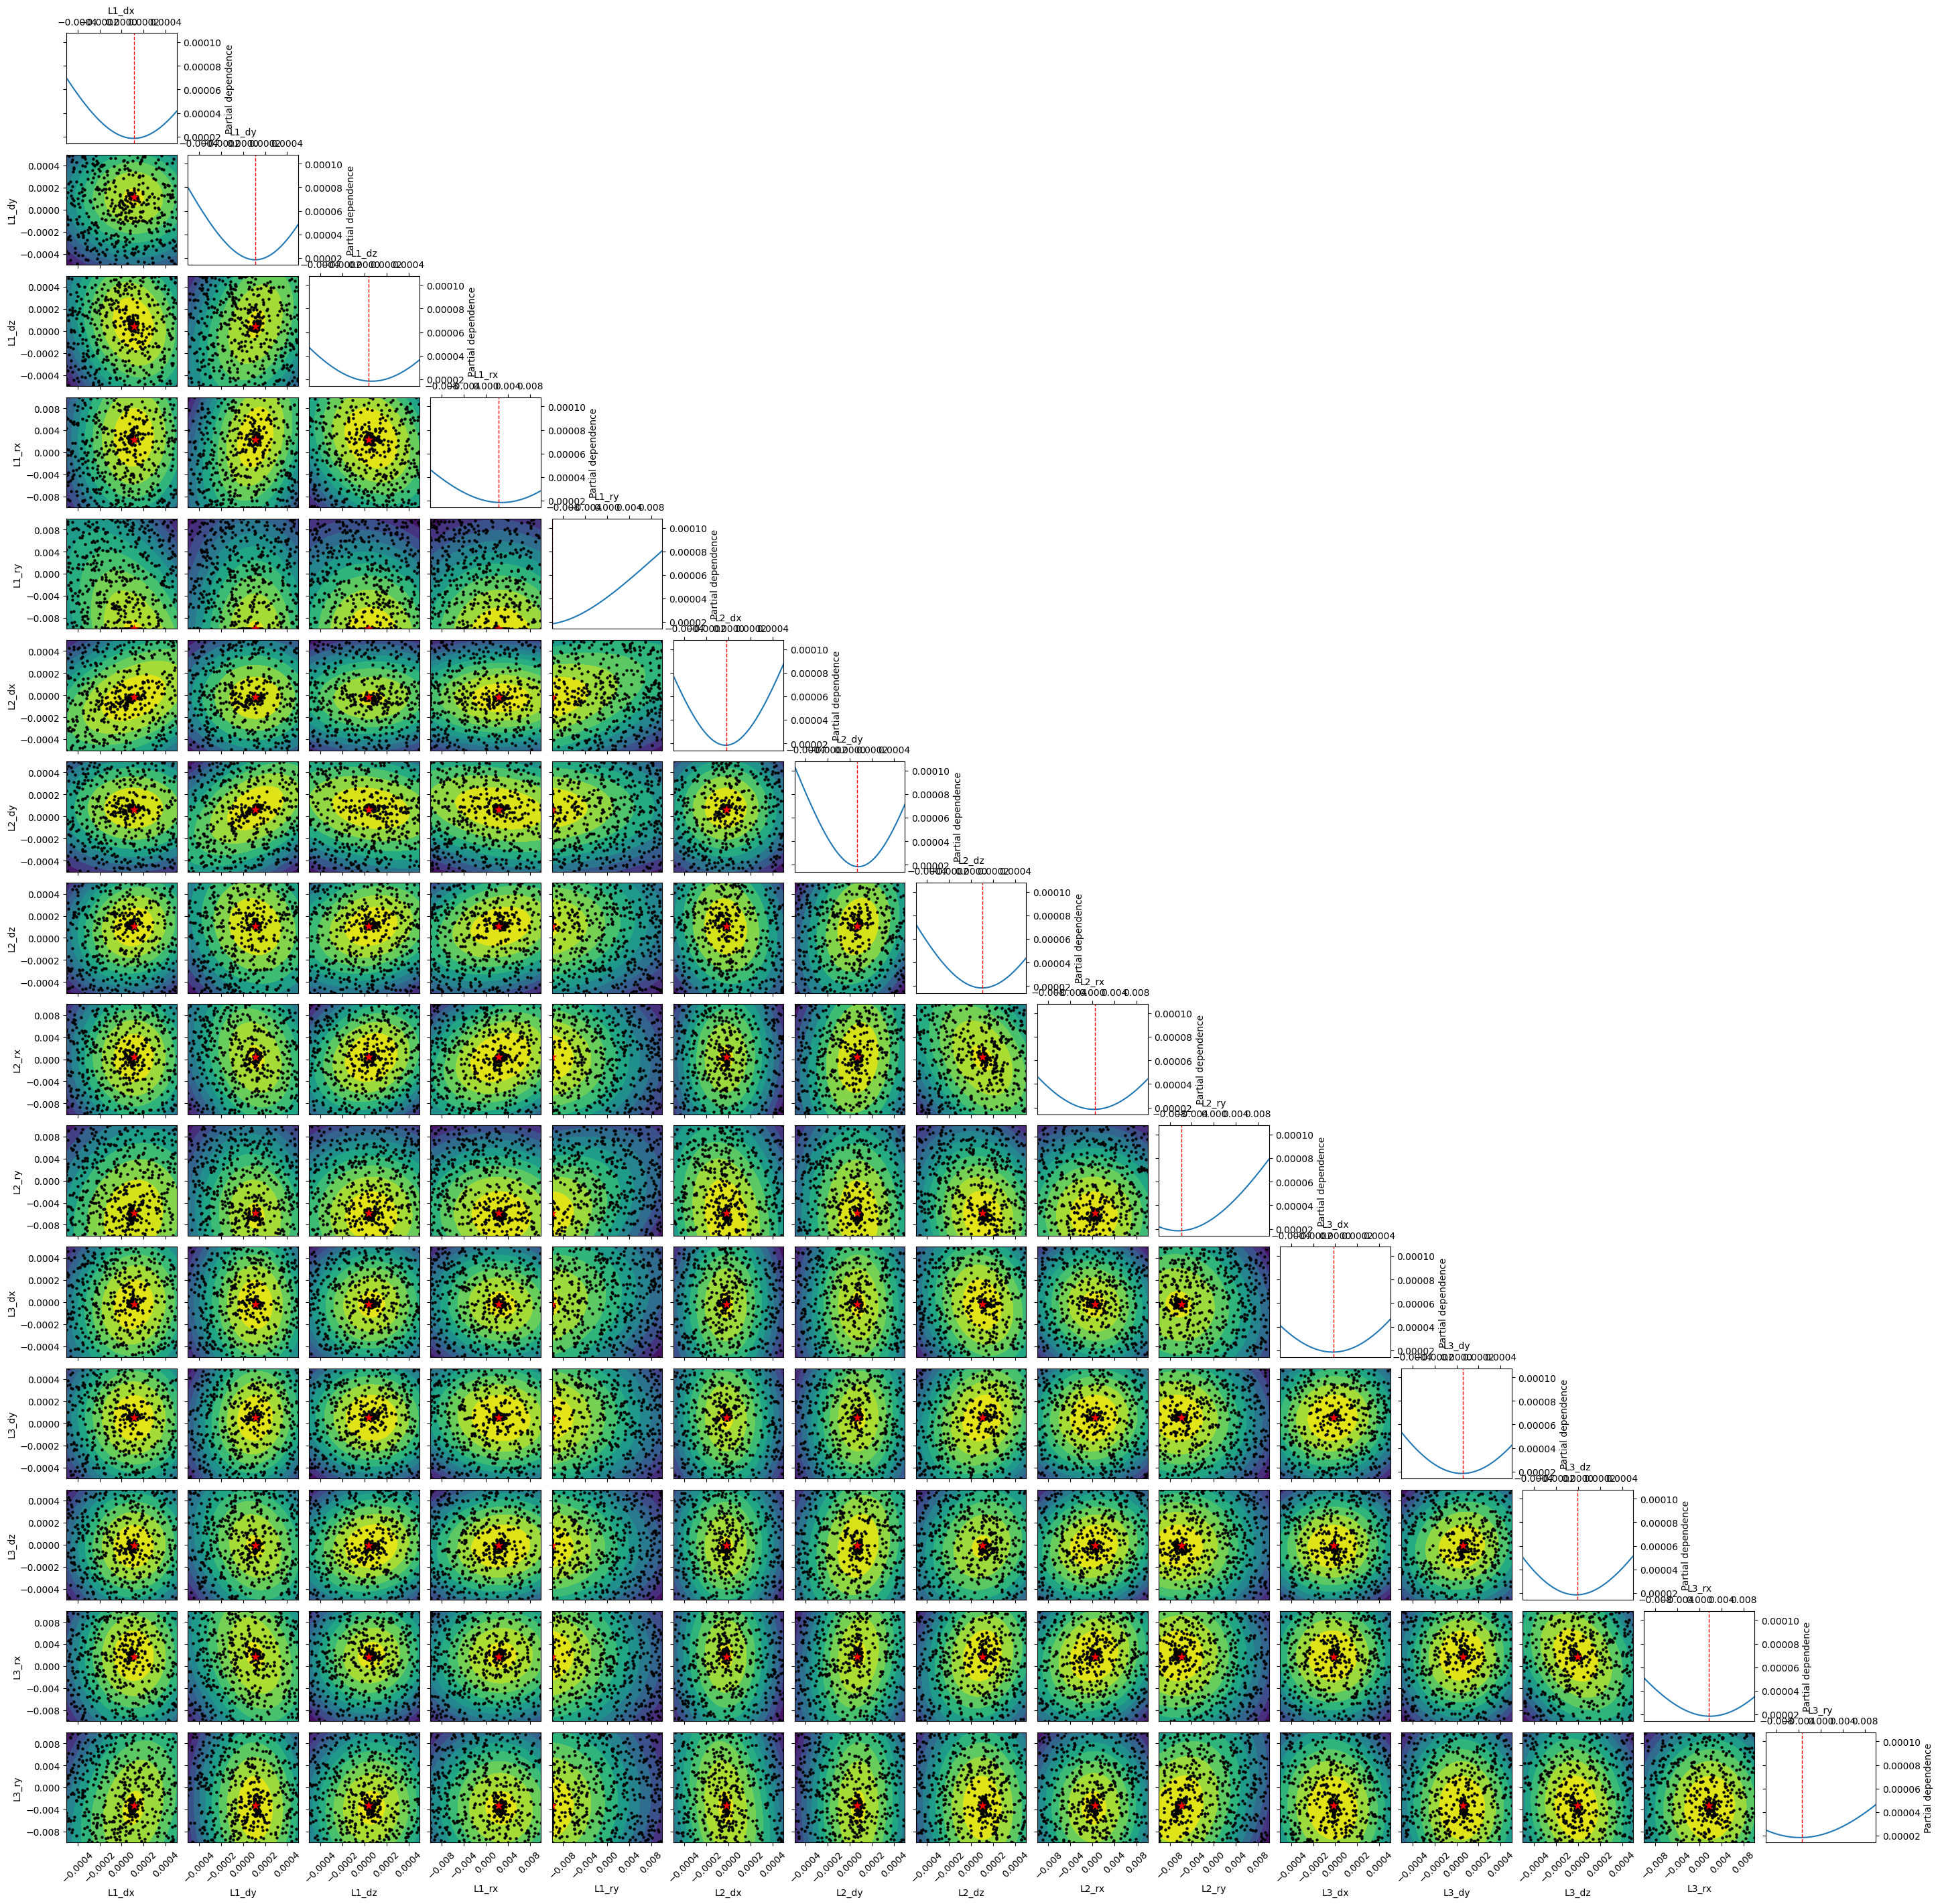

In [30]:
labels = ["L1_dx", "L1_dy", "L1_dz", "L1_rx", "L1_ry",
          "L2_dx", "L2_dy", "L2_dz", "L2_rx", "L2_ry",
          "L3_dx", "L3_dy", "L3_dz", "L3_rx", "L3_ry"]

_ = plot_objective(res,  sample_source='result', n_points=gp_ncalls, dimensions=labels)
